**UPD: This notebook seems to be popular, so I've improved it!**

Сhangelog (from version 6):
* TPU config code changed to be up to date with TF 2.4
* removed SKIP_VALIDATION flag (it's not required since we use external data and have enough training data)
* changed loss to 'categorical_crossentropy' and metric to Macro F-1 score (tfa.metrics.F1Score) (competition metric)
* changed ensembling to simple average of two models (optimal solution)
* reduced computation time per epoch
* models are now saved
* changed image size to 331

This notebook is designed to show how EfficientNetB7 and DenseNet201 models ensemble can be used with TPU. It is based on [my earlier notebook](https://www.kaggle.com/atamazian/flower-classification-ensemble-effnet-densenet), and it uses [external data](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec) to increase model's accuracy.

Some cool notebooks I've used to write this one:
* [Getting started with 100+ flowers on TPU](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu) by Martine Goerner
* [TPU Flowers](https://www.kaggle.com/tusharkendre/tpu-flowers) by Tushar Kendre and Shreyaansh Gupta (random_blockout augmentation)
* [TPU: ENet B7 + DenseNet](https://www.kaggle.com/wrrosa/tpu-enet-b7-densenet) by Wojtek Rosa

I also recommend [Rotation Augmentation GPU/TPU - [0.96+]](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96) by Chris Deotte

Have any suggestions? Feel free to comment.

**<span style="color:red">If you liked this kernel, please don't forget to upvote it!</span>**

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, os, random
import tensorflow as tf
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("TF version " + tf.__version__)

2021-11-22 09:44:51.431262: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-22 09:44:51.431457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TF version 2.4.1


# TPU detection

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

2021-11-22 09:44:58.368461: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-22 09:44:58.371424: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-22 09:44:58.371513: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 09:44:58.371544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2f23edef00ab): /proc/driver/nvidia/version does not exist
2021-11-22 09:44:58.374782: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of accelerators:  8


# Configuration

In [4]:
IMAGE_SIZE = [331, 331] # 192, 224, 331, 512
EPOCHS = 35
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print(strategy.num_replicas_in_sync)

8


# Data access and classes

TPUs read data directly from Google Cloud Storage (GCS), so we need to copy the dataset to a GCS bucket co-located with the TPU. To do that, pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. 

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

# External data
GCS_PATH_SELECT_EXT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
GCS_PATH_EXT = GCS_PATH_SELECT_EXT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + GCS_PATH_EXT + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + GCS_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + GCS_PATH_EXT + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + GCS_PATH_EXT + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + GCS_PATH_EXT + '/*.tfrec')

ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                          # 100 - 102

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition 

TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES

2021-11-22 09:45:05.338356: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-22 09:45:05.445051: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-22 09:45:05.511736: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-22 09:45:05.577528: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-22 09:45:05.644438: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Visualization functions

A set of functions to visualize data.

In [6]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Random blockout augmentation

In [7]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

# Dataset functions

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def onehot(image,label):
    return image,tf.one_hot(label, len(CLASSES))

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.

    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image, label

def data_hflip(image, idnum):
    image = tf.image.flip_left_right(image)
    return image, idnum

def get_training_dataset(do_onehot=False):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, do_onehot=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False, augmented=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.map(data_hflip, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


In [9]:
TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

# Dataset visualizations

In [10]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
Training data label examples: [47 51 59 ... 73 69 28]
Validation data shapes:


2021-11-22 09:45:11.959730: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 40, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1637574311.956325830","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 40, Output num: 0","grpc_status":3}


(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
Validation data label examples: [49 67 48 ... 48 67 50]
Test data shapes:
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
Test data IDs: ['72c2a5cb0' 'b5860475f' 'cf1ad8706' ... 'd69c942d9' '345b6fc68' '05bd91dd4']


In [11]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)


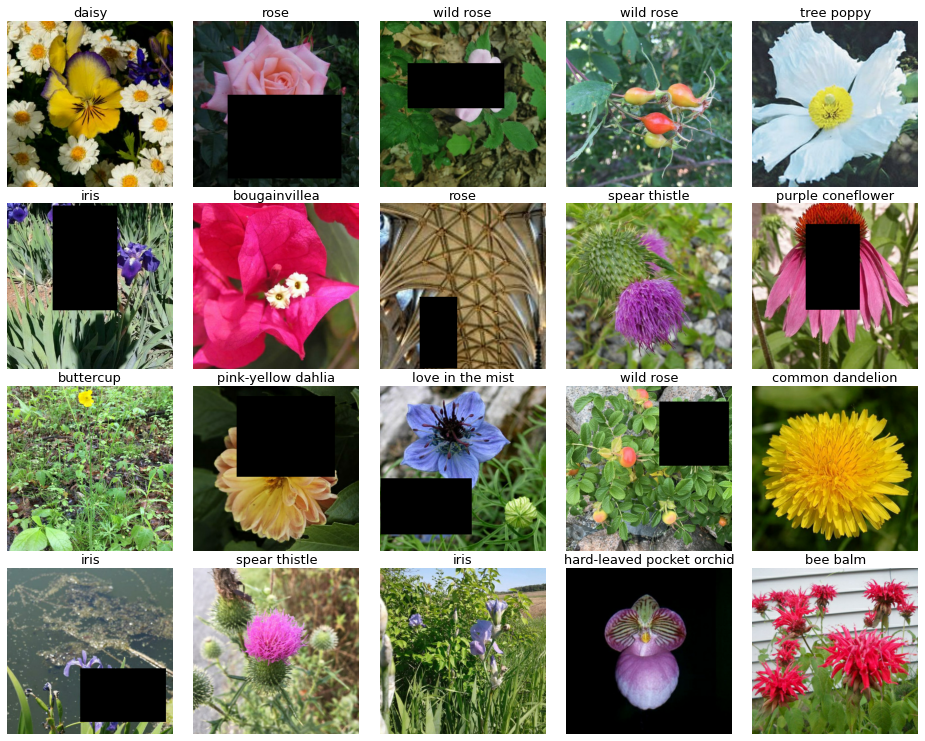

In [12]:
display_batch_of_images(next(train_batch))

In [13]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

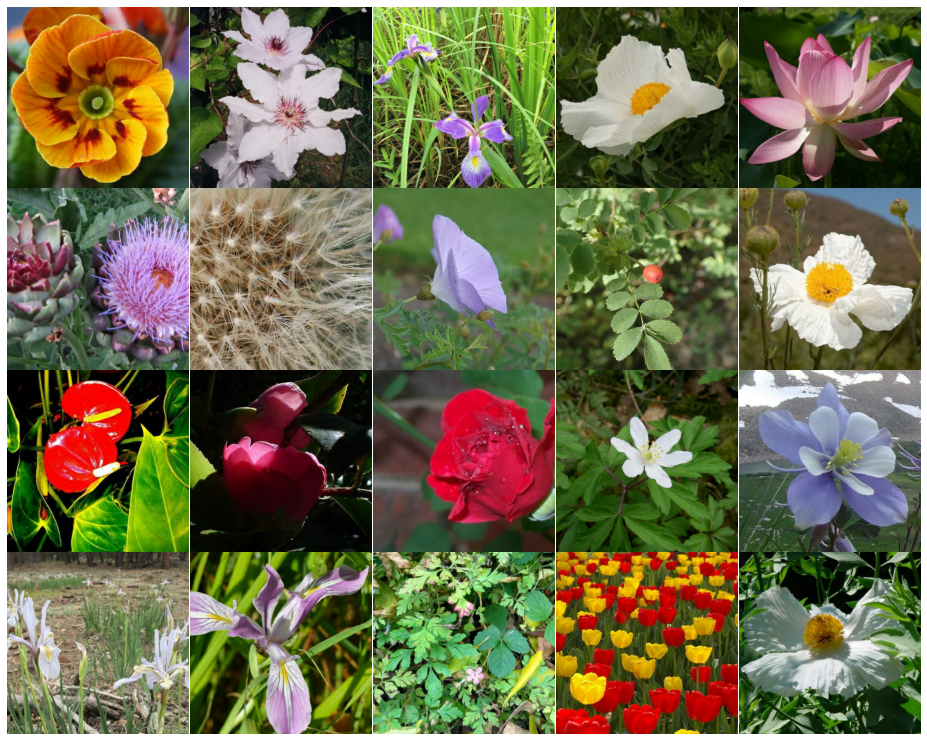

In [14]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

# Models and training

## Custom LR scheduler

Learning rate schedule: 1e-05 to 0.0004 to 1.06e-05


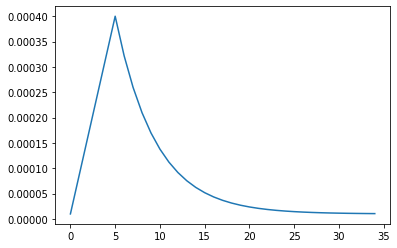

In [15]:
# custom LR scheduler
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [16]:
def get_model(base_model):
    base_model.trainable = True
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=[tfa.metrics.F1Score(len(CLASSES), average='macro')],
        # NEW on TPU in TensorFlow 24: sending multiple batches to the TPU at once saves communications
        # overheads and allows the XLA compiler to unroll the loop on TPU and optimize hardware utilization.
        steps_per_execution=16
    )
    return model

## EfficientNet B7

In [17]:
with strategy.scope():
    enet = efn.EfficientNetB7(weights='noisy-student', 
                            include_top=False,
                            pooling='avg',
                            input_shape=(*IMAGE_SIZE, 3))
    model1 = get_model(enet)
    
model1.summary()

258072576/258068648 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [18]:
chk_callback1 = tf.keras.callbacks.ModelCheckpoint('effnetb7_best.h5',
                                                   save_weights_only=True,
                                                   monitor='val_f1_score',
                                                   mode='max',
                                                   save_best_only=True,
                                                   verbose=1)
         
history1 = model1.fit(get_training_dataset(do_onehot=True), 
                steps_per_epoch=STEPS_PER_EPOCH, 
                epochs=EPOCHS, 
                validation_data=get_validation_dataset(do_onehot=True),
                validation_steps=VALIDATION_STEPS,
                callbacks=[lr_callback, chk_callback1],
                verbose=2)

Epoch 1/35

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
531/531 - 465s - loss: 4.2174 - f1_score: 0.0375 - val_loss: 4.0529 - val_f1_score: 0.0593

Epoch 00001: val_f1_score improved from -inf to 0.05929, saving model to effnetb7_best.h5
Epoch 2/35

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
531/531 - 175s - loss: 1.6095 - f1_score: 0.3750 - val_loss: 1.2909 - val_f1_score: 0.5668

Epoch 00002: val_f1_score improved from 0.05929 to 0.56677, saving model to effnetb7_best.h5
Epoch 3/35

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
531/531 - 175s - loss: 0.7067 - f1_score: 0.7225 - val_loss: 0.9431 - val_f1_score: 0.6896

Epoch 00003: val_f1_score improved from 0.56677 to 0.68957, saving model to effnetb7_best.h5
Epoch 4/35

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
531/531 - 176s - loss: 0.5106 - f1_score: 0.8289 - val_loss: 0.7561 - val_f1_score: 0.7853

Epoch 00004: val_f1_score im

## DenseNet201

In [19]:
with strategy.scope():
    densenet = tf.keras.applications.DenseNet201(weights='imagenet', 
                                                include_top=False,
                                                pooling='avg',
                                                input_shape=(*IMAGE_SIZE, 3))
    model2 = get_model(densenet)
    
model2.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [20]:
chk_callback2 = tf.keras.callbacks.ModelCheckpoint('densenet201_best.h5',
                                                   save_weights_only=True,
                                                   monitor='val_f1_score',
                                                   mode='max',
                                                   save_best_only=True,
                                                   verbose=1)

history2 = model2.fit(get_training_dataset(do_onehot=True), 
                steps_per_epoch=STEPS_PER_EPOCH, 
                epochs=EPOCHS, 
                validation_data=get_validation_dataset(do_onehot=True),
                validation_steps=VALIDATION_STEPS,
                callbacks=[lr_callback, chk_callback2],
                verbose=2)

Epoch 1/35

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
531/531 - 360s - loss: 2.7826 - f1_score: 0.1820 - val_loss: 2.0177 - val_f1_score: 0.3085

Epoch 00001: val_f1_score improved from -inf to 0.30851, saving model to densenet201_best.h5
Epoch 2/35

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
531/531 - 99s - loss: 0.8384 - f1_score: 0.6483 - val_loss: 0.8362 - val_f1_score: 0.7283

Epoch 00002: val_f1_score improved from 0.30851 to 0.72830, saving model to densenet201_best.h5
Epoch 3/35

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
531/531 - 108s - loss: 0.4729 - f1_score: 0.8448 - val_loss: 1.1499 - val_f1_score: 0.6180

Epoch 00003: val_f1_score did not improve from 0.72830
Epoch 4/35

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
531/531 - 98s - loss: 0.3950 - f1_score: 0.8767 - val_loss: 1.4161 - val_f1_score: 0.5649

Epoch 00004: val_f1_score did not improve from 0.72830
Epoch 5

# Confusion matrix

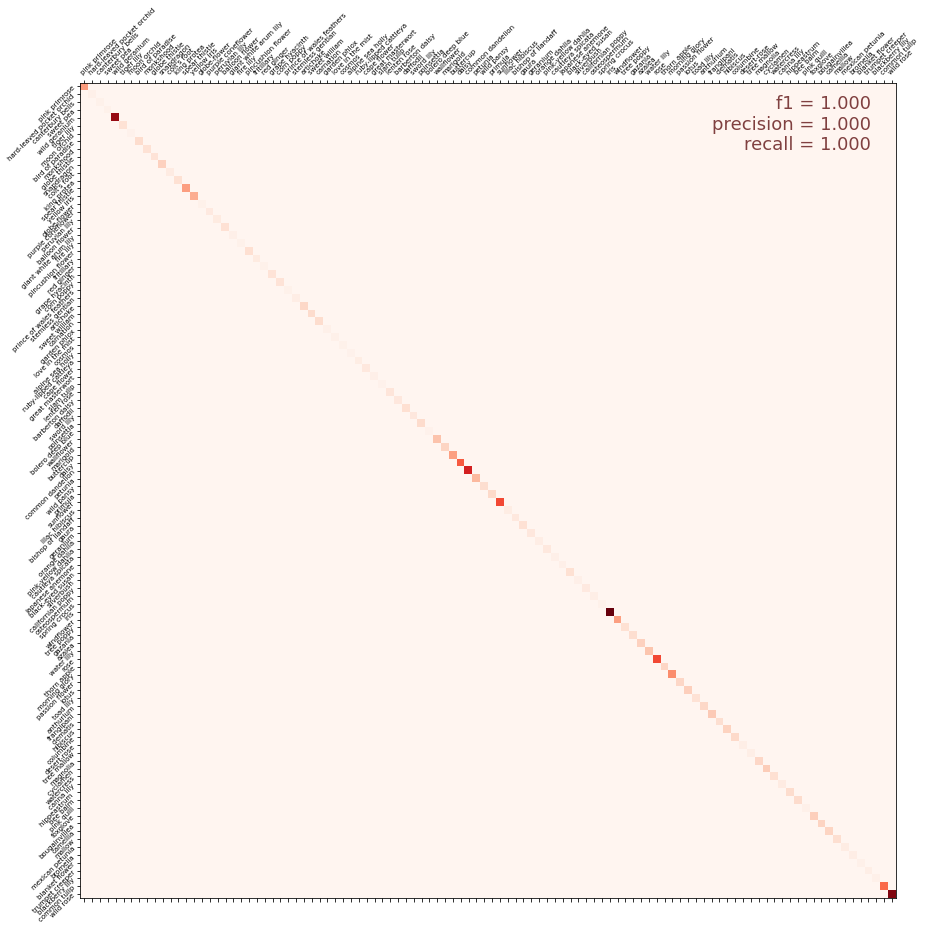

f1 score: 1.000, precision: 1.000, recall: 1.000


In [21]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
m1 = model1.predict(images_ds, steps=VALIDATION_STEPS)
m2 = model2.predict(images_ds, steps=VALIDATION_STEPS)

cm_probabilities = (m1 + m2)/2
cm_predictions = np.argmax(cm_probabilities, axis=-1)
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
#cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Predictions

In [22]:
def run_inference(model):
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    preds = model.predict(test_images_ds,verbose=0, steps=TEST_STEPS)
    return preds

In [23]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Calculating predictions...')
probs1 = run_inference(model1)
probs2 = run_inference(model2)
probabilities = (probs1 + probs2)/2
predictions = np.argmax(probabilities, axis=-1)

print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Calculating predictions...
Generating submission file...
